# **Analisis Prediksi Konsentrasi NO2 Menggunakan KNN Regression**

### **1. Pengambilan Data (Scraping)**

Data diambil dari sumber Dataspace Coneous yang menyediakan informasi cuaca dan kualitas udara. Scraping dilakukan untuk daerah **Surakarta** dan mengambil **periode 4 bulan penuh**, dengan mengambil variabel utama yaitu konsentrasi NO2 per hari.

Data mentah memiliki beberapa kolom, namun untuk keperluan analisis, hanya kolom NO2 dan tanggal (date) yang digunakan.

In [ ]:

import openeo
import pandas as pd
import matplotlib.pyplot as plt

# 1. Koneksi ke Copernicus Data Space
connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


In [ ]:
import os
aoi = {
    "type": "Polygon",
    "coordinates": [
          [
            [110.73384843270605, -7.506125504050544],
            [110.73384843270605, -7.629910709610229],
            [110.93095130302544, -7.629910709610229],
            [110.93095130302544, -7.506125504050544],
            [110.73384843270605, -7.506125504050544]
          ]
        ],
}

s5p = connection.load_collection(
    "SENTINEL_5P_L2",
    spatial_extent = {
        "west": 110.73384843270605,
        "south": -7.629910709610229,
        "east": 110.93095130302544,
        "north": -7.506125504050544
    },
    temporal_extent=["2025-01-01", "2025-04-01"],
    bands=["NO2"],
)

def mask_invalid(x):
    return x < 0

s5p_masked = s5p.mask(s5p.apply(mask_invalid))

daily_mean = s5p_masked.aggregate_temporal_period(period="day", reducer="mean")

daily_mean_aoi = daily_mean.aggregate_spatial(geometries=aoi, reducer="mean")

job = daily_mean_aoi.execute_batch(out_format="CSV")

results = job.get_results()
results.download_files("data-copernicus")

for f in os.listdir("data-copernicus"):
    if f.endswith(".csv"):
        df = pd.read_csv(os.path.join("data-copernicus", f))
        print("File ditemukan:", f)
        break

df["date"] = pd.to_datetime(df["date"])

df["month"] = df["date"].dt.to_period("M")

df_monthly = df.groupby("month", as_index=False)["NO2"].mean()
df

0:00:00 Job 'j-2511010835094139bae93865a9c70672': send 'start'
0:00:13 Job 'j-2511010835094139bae93865a9c70672': created (progress 0%)
0:00:19 Job 'j-2511010835094139bae93865a9c70672': created (progress 0%)
0:00:25 Job 'j-2511010835094139bae93865a9c70672': created (progress 0%)
0:00:34 Job 'j-2511010835094139bae93865a9c70672': created (progress 0%)
0:00:44 Job 'j-2511010835094139bae93865a9c70672': created (progress 0%)
0:00:56 Job 'j-2511010835094139bae93865a9c70672': created (progress 0%)
0:01:12 Job 'j-2511010835094139bae93865a9c70672': running (progress N/A)


In [ ]:
import pandas as pd

# Baca data
df = pd.read_csv('surakarta.csv')

# Ubah kolom 'date' ke tipe datetime
df["date"] = pd.to_datetime(df["date"])

# Urutkan berdasarkan kolom tanggal
df = df.sort_values(by="date")

# Buat kolom periode bulanan (opsional)
df["month"] = df["date"].dt.to_period("M")

# Hitung rata-rata NO2 per bulan (opsional)
df_monthly = df.groupby("month", as_index=False)["NO2"].mean()

# Simpan data yang sudah diurutkan ke file baru (atau overwrite file lama)
df.to_csv('surakarta_sorted.csv', index=False)

print("✅ Data berhasil diurutkan dan disimpan ke 'surakarta_sorted.csv'")


✅ Data berhasil diurutkan dan disimpan ke 'surakarta_sorted.csv'


C:\Users\ARII\AppData\Local\Temp\ipykernel_11700\3531368236.py:13: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["month"] = df["date"].dt.to_period("M")


In [ ]:

# Baca data
df = pd.read_csv('surakarta_sorted.csv')

**Mengecek dataset**

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           121 non-null    object 
 1   feature_index  121 non-null    int64  
 2   NO2            45 non-null     float64
 3   month          121 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 3.9+ KB
None


In [ ]:
print(df.head(10))

                        date  feature_index       NO2    month
0  2024-12-31 00:00:00+00:00              0       NaN  2024-12
1  2025-01-01 00:00:00+00:00              0       NaN  2025-01
2  2025-01-02 00:00:00+00:00              0       NaN  2025-01
3  2025-01-03 00:00:00+00:00              0       NaN  2025-01
4  2025-01-04 00:00:00+00:00              0       NaN  2025-01
5  2025-01-05 00:00:00+00:00              0       NaN  2025-01
6  2025-01-06 00:00:00+00:00              0  0.000030  2025-01
7  2025-01-07 00:00:00+00:00              0  0.000027  2025-01
8  2025-01-08 00:00:00+00:00              0       NaN  2025-01
9  2025-01-09 00:00:00+00:00              0  0.000040  2025-01


**Mengecek Jumlah Missing Value**

In [ ]:
df.isnull().sum()


date              0
feature_index     0
NO2              76
month             0
dtype: int64

**Visualisasi misisng value**

C:\Users\ARII\AppData\Local\Temp\ipykernel_22812\2610598959.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, y + 0.5, f'{int(y)} ({p[i]:.1f}%)', ha='center', fontsize=9)


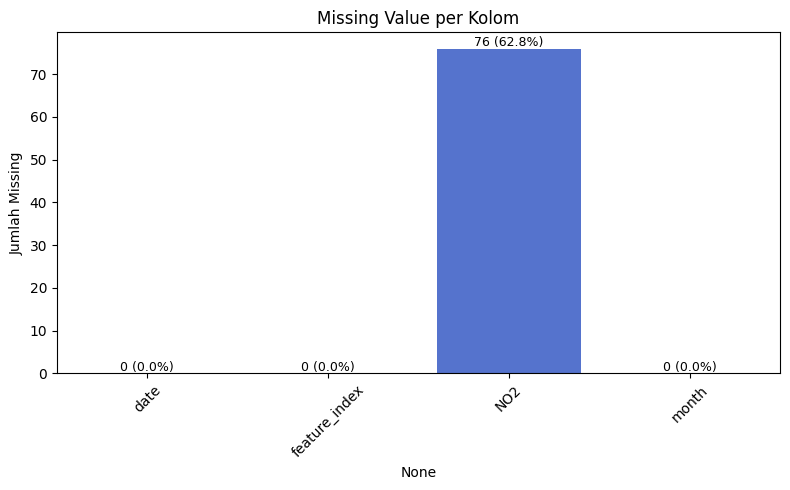

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

m = df.isnull().sum()
p = m / len(df) * 100

plt.figure(figsize=(8,5))
sns.barplot(x=m.index, y=m.values, color='royalblue')

for i, (x, y) in enumerate(zip(m.index, m.values)):
    plt.text(i, y + 0.5, f'{int(y)} ({p[i]:.1f}%)', ha='center', fontsize=9)

plt.title('Missing Value per Kolom')
plt.ylabel('Jumlah Missing')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### **3. Preprocessing Data NO2**

**a. Menangani Missing Values**

Pada dataset yang diunduh, ditemukan beberapa nilai hilang (missing values) di kolom NO2. Untuk menjaga kontinuitas data deret waktu (time series), nilai-nilai hilang diisi menggunakan metode interpolasi linear:

Metode ini memperkirakan nilai di antara dua titik data terdekat, menjaga kestabilan pola data.

In [ ]:
print(df['NO2'].isna().sum())

76


In [ ]:
df['NO2'] = df['NO2'].interpolate(method='linear')

In [ ]:
print(df['NO2'].isna().sum())
df[df['NO2'].isna()]

6


,date,feature_index,NO2,month
0,2024-12-31 00:00:00+00:00,0,NaN,2024-12
1,2025-01-01 00:00:00+00:00,0,NaN,2025-01
2,2025-01-02 00:00:00+00:00,0,NaN,2025-01
3,2025-01-03 00:00:00+00:00,0,NaN,2025-01
4,2025-01-04 00:00:00+00:00,0,NaN,2025-01
5,2025-01-05 00:00:00+00:00,0,NaN,2025-01


In [ ]:
df['NO2'] = df['NO2'].interpolate(method='linear').bfill()

In [ ]:
print(df['NO2'].isna().sum())

0


In [ ]:
df.head()

,date,feature_index,NO2,month
0,2024-12-31 00:00:00+00:00,0,0.00003,2024-12
1,2025-01-01 00:00:00+00:00,0,0.00003,2025-01
2,2025-01-02 00:00:00+00:00,0,0.00003,2025-01
3,2025-01-03 00:00:00+00:00,0,0.00003,2025-01
4,2025-01-04 00:00:00+00:00,0,0.00003,2025-01


#### **📈 Analisis Autokorelasi**

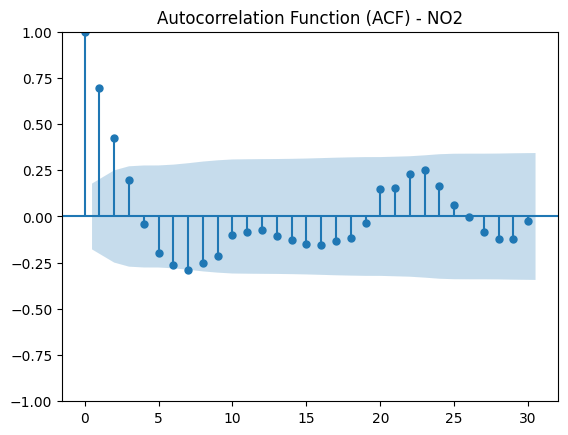

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df["NO2"], lags=30)
plt.title("Autocorrelation Function (ACF) - NO2")
plt.show()

### **4. Pembentukan Data Supervised**
Karena data NO2 bersifat deret waktu, maka dibentuk data supervised untuk memprediksi nilai ke depan berdasarkan beberapa nilai sebelumnya.

Tiga eksperimen dilakukan dengan variasi jumlah lag:

- Eksperimen 1: Menggunakan 3 lag (NO2-t3, NO2-t2, NO2-t1, NO2)
- Eksperimen 2: Menggunakan 4 lag (NO2-t4, NO2-t3, NO2-t2, NO2-t1, NO2)
- Eksperimen 3: Menggunakan 5 lag (NO2-t5, NO2-t4, NO2-t3, NO2-t2, NO2-t1, NO2)

Tujuannya adalah untuk melihat pengaruh jumlah lag terhadap performa model.

#### **Prediksi NO₂ MultiDays**

In [ ]:
import pandas as pd

def make_supervised_multiday(df, target_col='NO2', n_lags=10, n_steps=3):

    df_supervised = df.copy()
    for i in range(1, n_lags + 1):
        df_supervised[f'{target_col}_t-{i}'] = df_supervised[target_col].shift(i)

    for j in range(1, n_steps + 1):
        df_supervised[f'{target_col}_t+{j}'] = df_supervised[target_col].shift(-j)

    lag_cols = [f'{target_col}_t-{i}' for i in range(n_lags, 0, -1)]
    target_cols = [f'{target_col}_t+{j}' for j in range(1, n_steps + 1)]
    df_supervised = df_supervised[lag_cols + target_cols]
    df_supervised = df_supervised.dropna().reset_index(drop=True)

    return df_supervised


In [ ]:
df = df[['NO2']].copy().reset_index(drop=True)

# Ubah `n_steps` sesuai kebutuhan, misal prediksi 3 hari ke depan
n_steps = 3

# Eksperimen 1: 3 lag
df_exp1 = make_supervised_multiday(df, n_lags=3, n_steps=n_steps)
print("Eksperimen 1 (3 lag):")
print(df_exp1.head(), "\n")

# Eksperimen 2: 4 lag
df_exp2 = make_supervised_multiday(df, n_lags=4, n_steps=n_steps)
print("Eksperimen 2 (4 lag):")
print(df_exp2.head(), "\n")

# Eksperimen 3: 5 lag
df_exp3 = make_supervised_multiday(df, n_lags=5, n_steps=n_steps)
print("Eksperimen 3 (5 lag):")
print(df_exp3.head(), "\n")

# Eksperimen 4: 6 lag
df_exp4 = make_supervised_multiday(df, n_lags=6, n_steps=n_steps)
print("Eksperimen 4 (6 lag):")
print(df_exp4.head(), "\n")

# Eksperimen 5: 7 lag
df_exp5 = make_supervised_multiday(df, n_lags=7, n_steps=n_steps)
print("Eksperimen 5 (7 lag):")
print(df_exp5.head(), "\n")

# Eksperimen 6: 8 lag
df_exp6 = make_supervised_multiday(df, n_lags=8, n_steps=n_steps)
print("Eksperimen 6 (8 lag):")
print(df_exp6.head(), "\n")

# Eksperimen 7: 9 lag
df_exp7 = make_supervised_multiday(df, n_lags=9, n_steps=n_steps)
print("Eksperimen 7 (9 lag):")
print(df_exp7.head(), "\n")

# Eksperimen 8: 10 lag
df_exp8 = make_supervised_multiday(df, n_lags=10, n_steps=n_steps)
print("Eksperimen 8 (10 lag):")
print(df_exp8.head(), "\n")

Eksperimen 1 (3 lag):
   NO2_t-3  NO2_t-2  NO2_t-1   NO2_t+1   NO2_t+2   NO2_t+3
0  0.00003  0.00003  0.00003  0.000030  0.000030  0.000030
1  0.00003  0.00003  0.00003  0.000030  0.000030  0.000027
2  0.00003  0.00003  0.00003  0.000030  0.000027  0.000033
3  0.00003  0.00003  0.00003  0.000027  0.000033  0.000040
4  0.00003  0.00003  0.00003  0.000033  0.000040  0.000036 

Eksperimen 2 (4 lag):
   NO2_t-4  NO2_t-3  NO2_t-2   NO2_t-1   NO2_t+1   NO2_t+2   NO2_t+3
0  0.00003  0.00003  0.00003  0.000030  0.000030  0.000030  0.000027
1  0.00003  0.00003  0.00003  0.000030  0.000030  0.000027  0.000033
2  0.00003  0.00003  0.00003  0.000030  0.000027  0.000033  0.000040
3  0.00003  0.00003  0.00003  0.000030  0.000033  0.000040  0.000036
4  0.00003  0.00003  0.00003  0.000027  0.000040  0.000036  0.000020 

Eksperimen 3 (5 lag):
   NO2_t-5  NO2_t-4  NO2_t-3   NO2_t-2   NO2_t-1   NO2_t+1   NO2_t+2   NO2_t+3
0  0.00003  0.00003  0.00003  0.000030  0.000030  0.000030  0.000027  0.000033
1  0

In [ ]:
print(len(df_exp1))
print(len(df_exp2))
print(len(df_exp3))
print(len(df_exp4))
print(len(df_exp5))
print(len(df_exp6))
print(len(df_exp7))
print(len(df_exp8))


115
114
113
112
111
110
109
108


In [ ]:
import os

folder = "data_supervised_multiday"
os.makedirs(folder, exist_ok=True)

df_exp1.to_csv(os.path.join(folder, 'supervised_lag1_multiday.csv'), index=False)
df_exp2.to_csv(os.path.join(folder, 'supervised_lag2_multiday.csv'), index=False)
df_exp3.to_csv(os.path.join(folder, 'supervised_lag3_multiday.csv'), index=False)
df_exp4.to_csv(os.path.join(folder, 'supervised_lag4_multiday.csv'), index=False)
df_exp5.to_csv(os.path.join(folder, 'supervised_lag5_multiday.csv'), index=False)
df_exp6.to_csv(os.path.join(folder, 'supervised_lag6_multiday.csv'), index=False)
df_exp7.to_csv(os.path.join(folder, 'supervised_lag7_multiday.csv'), index=False)
df_exp8.to_csv(os.path.join(folder, 'supervised_lag8_multiday.csv'), index=False)

print(f"✅ Semua dataset supervised sudah disimpan ke folder: '{folder}/'")

✅ Semua dataset supervised sudah disimpan ke folder: 'data_supervised_multiday/'


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

In [ ]:
df_exp1 = pd.read_csv('data_supervised_multiday/supervised_lag1_multiday.csv')
df_exp2 = pd.read_csv('data_supervised_multiday/supervised_lag2_multiday.csv')
df_exp3 = pd.read_csv('data_supervised_multiday/supervised_lag3_multiday.csv')
df_exp4 = pd.read_csv('data_supervised_multiday/supervised_lag4_multiday.csv')
df_exp5 = pd.read_csv('data_supervised_multiday/supervised_lag5_multiday.csv')
df_exp6 = pd.read_csv('data_supervised_multiday/supervised_lag6_multiday.csv')
df_exp7 = pd.read_csv('data_supervised_multiday/supervised_lag7_multiday.csv')
df_exp8 = pd.read_csv('data_supervised_multiday/supervised_lag8_multiday.csv')


In [ ]:
df_exp1

,NO2_t-3,NO2_t-2,NO2_t-1,NO2_t+1,NO2_t+2,NO2_t+3
0,0.000030,0.000030,0.000030,0.000030,0.000030,0.000030
1,0.000030,0.000030,0.000030,0.000030,0.000030,0.000027
2,0.000030,0.000030,0.000030,0.000030,0.000027,0.000033
3,0.000030,0.000030,0.000030,0.000027,0.000033,0.000040
4,0.000030,0.000030,0.000030,0.000033,0.000040,0.000036
...,...,...,...,...,...,...
110,0.000028,0.000025,0.000021,0.000020,0.000046,0.000025
111,0.000025,0.000021,0.000022,0.000046,0.000025,0.000023
112,0.000021,0.000022,0.000020,0.000025,0.000023,0.000028
113,0.000022,0.000020,0.000046,0.000023,0.000028,0.000024


In [ ]:
df_exp2

,NO2_t-4,NO2_t-3,NO2_t-2,NO2_t-1,NO2_t+1,NO2_t+2,NO2_t+3
0,0.000030,0.000030,0.000030,0.000030,0.000030,0.000030,0.000027
1,0.000030,0.000030,0.000030,0.000030,0.000030,0.000027,0.000033
2,0.000030,0.000030,0.000030,0.000030,0.000027,0.000033,0.000040
3,0.000030,0.000030,0.000030,0.000030,0.000033,0.000040,0.000036
4,0.000030,0.000030,0.000030,0.000027,0.000040,0.000036,0.000020
...,...,...,...,...,...,...,...
109,0.000031,0.000028,0.000025,0.000021,0.000020,0.000046,0.000025
110,0.000028,0.000025,0.000021,0.000022,0.000046,0.000025,0.000023
111,0.000025,0.000021,0.000022,0.000020,0.000025,0.000023,0.000028
112,0.000021,0.000022,0.000020,0.000046,0.000023,0.000028,0.000024


In [ ]:
df_exp3

,NO2_t-5,NO2_t-4,NO2_t-3,NO2_t-2,NO2_t-1,NO2_t+1,NO2_t+2,NO2_t+3
0,0.000030,0.000030,0.000030,0.000030,0.000030,0.000030,0.000027,0.000033
1,0.000030,0.000030,0.000030,0.000030,0.000030,0.000027,0.000033,0.000040
2,0.000030,0.000030,0.000030,0.000030,0.000030,0.000033,0.000040,0.000036
3,0.000030,0.000030,0.000030,0.000030,0.000027,0.000040,0.000036,0.000020
4,0.000030,0.000030,0.000030,0.000027,0.000033,0.000036,0.000020,0.000022
...,...,...,...,...,...,...,...,...
108,0.000033,0.000031,0.000028,0.000025,0.000021,0.000020,0.000046,0.000025
109,0.000031,0.000028,0.000025,0.000021,0.000022,0.000046,0.000025,0.000023
110,0.000028,0.000025,0.000021,0.000022,0.000020,0.000025,0.000023,0.000028
111,0.000025,0.000021,0.000022,0.000020,0.000046,0.000023,0.000028,0.000024


In [ ]:
df_exp4

,NO2_t-6,NO2_t-5,NO2_t-4,NO2_t-3,NO2_t-2,NO2_t-1,NO2_t+1,NO2_t+2,NO2_t+3
0,0.000030,0.000030,0.000030,0.000030,0.000030,0.000030,0.000027,0.000033,0.000040
1,0.000030,0.000030,0.000030,0.000030,0.000030,0.000030,0.000033,0.000040,0.000036
2,0.000030,0.000030,0.000030,0.000030,0.000030,0.000027,0.000040,0.000036,0.000020
3,0.000030,0.000030,0.000030,0.000030,0.000027,0.000033,0.000036,0.000020,0.000022
4,0.000030,0.000030,0.000030,0.000027,0.000033,0.000040,0.000020,0.000022,0.000023
...,...,...,...,...,...,...,...,...,...
107,0.000035,0.000033,0.000031,0.000028,0.000025,0.000021,0.000020,0.000046,0.000025
108,0.000033,0.000031,0.000028,0.000025,0.000021,0.000022,0.000046,0.000025,0.000023
109,0.000031,0.000028,0.000025,0.000021,0.000022,0.000020,0.000025,0.000023,0.000028
110,0.000028,0.000025,0.000021,0.000022,0.000020,0.000046,0.000023,0.000028,0.000024


In [ ]:
df_exp5

,NO2_t-7,NO2_t-6,NO2_t-5,NO2_t-4,NO2_t-3,NO2_t-2,NO2_t-1,NO2_t+1,NO2_t+2,NO2_t+3
0,0.000030,0.000030,0.000030,0.000030,0.000030,0.000030,0.000030,0.000033,0.000040,0.000036
1,0.000030,0.000030,0.000030,0.000030,0.000030,0.000030,0.000027,0.000040,0.000036,0.000020
2,0.000030,0.000030,0.000030,0.000030,0.000030,0.000027,0.000033,0.000036,0.000020,0.000022
3,0.000030,0.000030,0.000030,0.000030,0.000027,0.000033,0.000040,0.000020,0.000022,0.000023
4,0.000030,0.000030,0.000030,0.000027,0.000033,0.000040,0.000036,0.000022,0.000023,0.000025
...,...,...,...,...,...,...,...,...,...,...
106,0.000037,0.000035,0.000033,0.000031,0.000028,0.000025,0.000021,0.000020,0.000046,0.000025
107,0.000035,0.000033,0.000031,0.000028,0.000025,0.000021,0.000022,0.000046,0.000025,0.000023
108,0.000033,0.000031,0.000028,0.000025,0.000021,0.000022,0.000020,0.000025,0.000023,0.000028
109,0.000031,0.000028,0.000025,0.000021,0.000022,0.000020,0.000046,0.000023,0.000028,0.000024


In [ ]:
df_exp6

,NO2_t-8,NO2_t-7,NO2_t-6,NO2_t-5,NO2_t-4,NO2_t-3,NO2_t-2,NO2_t-1,NO2_t+1,NO2_t+2,NO2_t+3
0,0.000030,0.000030,0.000030,0.000030,0.000030,0.000030,0.000030,0.000027,0.000040,0.000036,0.000020
1,0.000030,0.000030,0.000030,0.000030,0.000030,0.000030,0.000027,0.000033,0.000036,0.000020,0.000022
2,0.000030,0.000030,0.000030,0.000030,0.000030,0.000027,0.000033,0.000040,0.000020,0.000022,0.000023
3,0.000030,0.000030,0.000030,0.000030,0.000027,0.000033,0.000040,0.000036,0.000022,0.000023,0.000025
4,0.000030,0.000030,0.000030,0.000027,0.000033,0.000040,0.000036,0.000020,0.000023,0.000025,0.000027
...,...,...,...,...,...,...,...,...,...,...,...
105,0.000039,0.000037,0.000035,0.000033,0.000031,0.000028,0.000025,0.000021,0.000020,0.000046,0.000025
106,0.000037,0.000035,0.000033,0.000031,0.000028,0.000025,0.000021,0.000022,0.000046,0.000025,0.000023
107,0.000035,0.000033,0.000031,0.000028,0.000025,0.000021,0.000022,0.000020,0.000025,0.000023,0.000028
108,0.000033,0.000031,0.000028,0.000025,0.000021,0.000022,0.000020,0.000046,0.000023,0.000028,0.000024


In [ ]:
df_exp7

,NO2_t-9,NO2_t-8,NO2_t-7,NO2_t-6,NO2_t-5,NO2_t-4,NO2_t-3,NO2_t-2,NO2_t-1,NO2_t+1,NO2_t+2,NO2_t+3
0,0.000030,0.000030,0.000027,0.000033,0.000040,0.000036,0.000020,0.000022,0.000023,0.000027,0.000028,0.000030
1,0.000030,0.000027,0.000033,0.000040,0.000036,0.000020,0.000022,0.000023,0.000025,0.000028,0.000030,0.000031
2,0.000027,0.000033,0.000040,0.000036,0.000020,0.000022,0.000023,0.000025,0.000027,0.000030,0.000031,0.000031
3,0.000033,0.000040,0.000036,0.000020,0.000022,0.000023,0.000025,0.000027,0.000028,0.000031,0.000031,0.000031
4,0.000040,0.000036,0.000020,0.000022,0.000023,0.000025,0.000027,0.000028,0.000030,0.000031,0.000031,0.000031
...,...,...,...,...,...,...,...,...,...,...,...,...
99,0.000032,0.000039,0.000037,0.000035,0.000033,0.000031,0.000028,0.000025,0.000021,0.000020,0.000046,0.000025
100,0.000039,0.000037,0.000035,0.000033,0.000031,0.000028,0.000025,0.000021,0.000022,0.000046,0.000025,0.000023
101,0.000037,0.000035,0.000033,0.000031,0.000028,0.000025,0.000021,0.000022,0.000020,0.000025,0.000023,0.000028
102,0.000035,0.000033,0.000031,0.000028,0.000025,0.000021,0.000022,0.000020,0.000046,0.000023,0.000028,0.000024


In [ ]:
df_exp8

,NO2_t-10,NO2_t-9,NO2_t-8,NO2_t-7,NO2_t-6,NO2_t-5,NO2_t-4,NO2_t-3,NO2_t-2,NO2_t-1,NO2_t+1,NO2_t+2,NO2_t+3
0,0.000030,0.000030,0.000027,0.000033,0.000040,0.000036,0.000020,0.000022,0.000023,0.000025,0.000028,0.000030,0.000031
1,0.000030,0.000027,0.000033,0.000040,0.000036,0.000020,0.000022,0.000023,0.000025,0.000027,0.000030,0.000031,0.000031
2,0.000027,0.000033,0.000040,0.000036,0.000020,0.000022,0.000023,0.000025,0.000027,0.000028,0.000031,0.000031,0.000031
3,0.000033,0.000040,0.000036,0.000020,0.000022,0.000023,0.000025,0.000027,0.000028,0.000030,0.000031,0.000031,0.000031
4,0.000040,0.000036,0.000020,0.000022,0.000023,0.000025,0.000027,0.000028,0.000030,0.000031,0.000031,0.000031,0.000031
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,0.000025,0.000032,0.000039,0.000037,0.000035,0.000033,0.000031,0.000028,0.000025,0.000021,0.000020,0.000046,0.000025
99,0.000032,0.000039,0.000037,0.000035,0.000033,0.000031,0.000028,0.000025,0.000021,0.000022,0.000046,0.000025,0.000023
100,0.000039,0.000037,0.000035,0.000033,0.000031,0.000028,0.000025,0.000021,0.000022,0.000020,0.000025,0.000023,0.000028
101,0.000037,0.000035,0.000033,0.000031,0.000028,0.000025,0.000021,0.000022,0.000020,0.000046,0.000023,0.000028,0.000024


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import os

data_path = 'data_supervised_multiday/supervised_lag1_multiday.csv'  # ubah sesuai file multi-day kamu
df = pd.read_csv(data_path)

# Misal prediksi 3 hari ke depan → target: NO2_t+1, NO2_t+2, NO2_t+3
target_cols = [col for col in df.columns if 't+' in col]
feature_cols = [col for col in df.columns if 't-' in col]

X = df[feature_cols]
y = df[target_cols]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Simpan min-max untuk referensi
min_values = scaler.data_min_
max_values = scaler.data_max_

print("\n📊 Nilai Min-Max fitur:")
for col, minv, maxv in zip(X.columns, min_values, max_values):
    print(f"{col:10s} → Min: {minv:.8f} | Max: {maxv:.8f}")

k = 12
knn = KNeighborsRegressor(n_neighbors=k)
knn.fit(X_train_scaled, y_train)

# Prediksi multi-day
y_pred = knn.predict(X_test_scaled)
y_pred = pd.DataFrame(y_pred, columns=target_cols, index=y_test.index)

print("\n=== HASIL EVALUASI MODEL KNN (MULTI-DAY) ===")
print(f"File Data      : {data_path}")
print(f"Jumlah Data    : {len(df)} (Train: {len(X_train)}, Test: {len(X_test)})")
print(f"k (neighbors)  : {k}\n")

results = []
for col in target_cols:
    rmse = np.sqrt(mean_squared_error(y_test[col], y_pred[col]))
    mae = mean_absolute_error(y_test[col], y_pred[col])
    mape = mean_absolute_percentage_error(y_test[col], y_pred[col]) * 100
    r2 = r2_score(y_test[col], y_pred[col])

    results.append([col, rmse, mae, mape, r2])
    print(f"{col}:")
    print(f"  RMSE : {rmse:.8f}")
    print(f"  MAE  : {mae:.8f}")
    print(f"  MAPE : {mape:.2f}%")
    print(f"  R²   : {r2:.4f}\n")

# Ringkasan evaluasi
results_df = pd.DataFrame(results, columns=['Target', 'RMSE', 'MAE', 'MAPE', 'R²'])
print("=== RINGKASAN HASIL ===")
print(results_df)

folder = "hasil_prediksi_knn_multiday"
os.makedirs(folder, exist_ok=True)

base_name = os.path.splitext(os.path.basename(data_path))[0]
output_df = pd.concat([y_test.reset_index(drop=True), y_pred.reset_index(drop=True)], axis=1)
output_name = os.path.join(folder, f"hasil_multi-day_{base_name}.csv")
output_df.to_csv(output_name, index=False)
print(f"\n✅ Hasil prediksi disimpan ke: {output_name}")

scaler_df = pd.DataFrame({'Feature': X.columns, 'Min': min_values, 'Max': max_values})
scaler_file = os.path.join(folder, f"scaler_min-max_{base_name}.csv")
scaler_df.to_csv(scaler_file, index=False)
print(f"✅ Parameter Min-Max disimpan ke: {scaler_file}")





📊 Nilai Min-Max fitur:
NO2_t-3    → Min: 0.00001438 | Max: 0.00005871
NO2_t-2    → Min: 0.00001323 | Max: 0.00005871
NO2_t-1    → Min: 0.00001207 | Max: 0.00005871

=== HASIL EVALUASI MODEL KNN (MULTI-DAY) ===
File Data      : data_supervised_multiday/supervised_lag1_multiday.csv
Jumlah Data    : 115 (Train: 92, Test: 23)
k (neighbors)  : 12

NO2_t+1:
  RMSE : 0.00000731
  MAE  : 0.00000561
  MAPE : 20.56%
  R²   : -0.2113

NO2_t+2:
  RMSE : 0.00000694
  MAE  : 0.00000542
  MAPE : 19.54%
  R²   : -0.0789

NO2_t+3:
  RMSE : 0.00000720
  MAE  : 0.00000552
  MAPE : 19.92%
  R²   : -0.1896

=== RINGKASAN HASIL ===
    Target      RMSE       MAE       MAPE        R²
0  NO2_t+1  0.000007  0.000006  20.556321 -0.211301
1  NO2_t+2  0.000007  0.000005  19.536654 -0.078923
2  NO2_t+3  0.000007  0.000006  19.919748 -0.189648

✅ Hasil prediksi disimpan ke: hasil_prediksi_knn_multiday\hasil_multi-day_supervised_lag1_multiday.csv
✅ Parameter Min-Max disimpan ke: hasil_prediksi_knn_multiday\scaler_m

In [ ]:
data_path = 'data_supervised_multiday/supervised_lag2_multiday.csv'  # ubah sesuai file multi-day kamu
df = pd.read_csv(data_path)

# Misal prediksi 3 hari ke depan → target: NO2_t+1, NO2_t+2, NO2_t+3
target_cols = [col for col in df.columns if 't+' in col]
feature_cols = [col for col in df.columns if 't-' in col]

X = df[feature_cols]
y = df[target_cols]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Simpan min-max untuk referensi
min_values = scaler.data_min_
max_values = scaler.data_max_

print("\n📊 Nilai Min-Max fitur:")
for col, minv, maxv in zip(X.columns, min_values, max_values):
    print(f"{col:10s} → Min: {minv:.8f} | Max: {maxv:.8f}")

k = 12
knn = KNeighborsRegressor(n_neighbors=k)
knn.fit(X_train_scaled, y_train)

# Prediksi multi-day
y_pred = knn.predict(X_test_scaled)
y_pred = pd.DataFrame(y_pred, columns=target_cols, index=y_test.index)

print("\n=== HASIL EVALUASI MODEL KNN (MULTI-DAY) ===")
print(f"File Data      : {data_path}")
print(f"Jumlah Data    : {len(df)} (Train: {len(X_train)}, Test: {len(X_test)})")
print(f"k (neighbors)  : {k}\n")

results = []
for col in target_cols:
    rmse = np.sqrt(mean_squared_error(y_test[col], y_pred[col]))
    mae = mean_absolute_error(y_test[col], y_pred[col])
    mape = mean_absolute_percentage_error(y_test[col], y_pred[col]) * 100
    r2 = r2_score(y_test[col], y_pred[col])

    results.append([col, rmse, mae, mape, r2])
    print(f"{col}:")
    print(f"  RMSE : {rmse:.8f}")
    print(f"  MAE  : {mae:.8f}")
    print(f"  MAPE : {mape:.2f}%")
    print(f"  R²   : {r2:.4f}\n")

# Ringkasan evaluasi
results_df = pd.DataFrame(results, columns=['Target', 'RMSE', 'MAE', 'MAPE', 'R²'])
print("=== RINGKASAN HASIL ===")
print(results_df)

folder = "hasil_prediksi_knn_multiday"
os.makedirs(folder, exist_ok=True)

base_name = os.path.splitext(os.path.basename(data_path))[0]
output_df = pd.concat([y_test.reset_index(drop=True), y_pred.reset_index(drop=True)], axis=1)
output_name = os.path.join(folder, f"hasil_multi-day_{base_name}.csv")
output_df.to_csv(output_name, index=False)
print(f"\n✅ Hasil prediksi disimpan ke: {output_name}")

scaler_df = pd.DataFrame({'Feature': X.columns, 'Min': min_values, 'Max': max_values})
scaler_file = os.path.join(folder, f"scaler_min-max_{base_name}.csv")
scaler_df.to_csv(scaler_file, index=False)
print(f"✅ Parameter Min-Max disimpan ke: {scaler_file}")





📊 Nilai Min-Max fitur:
NO2_t-4    → Min: 0.00001554 | Max: 0.00005871
NO2_t-3    → Min: 0.00001438 | Max: 0.00005871
NO2_t-2    → Min: 0.00001323 | Max: 0.00005871
NO2_t-1    → Min: 0.00001207 | Max: 0.00005871

=== HASIL EVALUASI MODEL KNN (MULTI-DAY) ===
File Data      : data_supervised_multiday/supervised_lag2_multiday.csv
Jumlah Data    : 114 (Train: 91, Test: 23)
k (neighbors)  : 12

NO2_t+1:
  RMSE : 0.00000706
  MAE  : 0.00000509
  MAPE : 18.95%
  R²   : -0.1310

NO2_t+2:
  RMSE : 0.00000696
  MAE  : 0.00000507
  MAPE : 18.19%
  R²   : -0.0841

NO2_t+3:
  RMSE : 0.00000677
  MAE  : 0.00000507
  MAPE : 18.27%
  R²   : -0.0510

=== RINGKASAN HASIL ===
    Target      RMSE       MAE       MAPE        R²
0  NO2_t+1  0.000007  0.000005  18.946548 -0.131009
1  NO2_t+2  0.000007  0.000005  18.194300 -0.084076
2  NO2_t+3  0.000007  0.000005  18.273612 -0.051041

✅ Hasil prediksi disimpan ke: hasil_prediksi_knn_multiday\hasil_multi-day_supervised_lag2_multiday.csv
✅ Parameter Min-Max di

In [ ]:
data_path = 'data_supervised_multiday/supervised_lag3_multiday.csv'  # ubah sesuai file multi-day kamu
df = pd.read_csv(data_path)

# Misal prediksi 3 hari ke depan → target: NO2_t+1, NO2_t+2, NO2_t+3
target_cols = [col for col in df.columns if 't+' in col]
feature_cols = [col for col in df.columns if 't-' in col]

X = df[feature_cols]
y = df[target_cols]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Simpan min-max untuk referensi
min_values = scaler.data_min_
max_values = scaler.data_max_

print("\n📊 Nilai Min-Max fitur:")
for col, minv, maxv in zip(X.columns, min_values, max_values):
    print(f"{col:10s} → Min: {minv:.8f} | Max: {maxv:.8f}")

k = 12
knn = KNeighborsRegressor(n_neighbors=k)
knn.fit(X_train_scaled, y_train)

# Prediksi multi-day
y_pred = knn.predict(X_test_scaled)
y_pred = pd.DataFrame(y_pred, columns=target_cols, index=y_test.index)

print("\n=== HASIL EVALUASI MODEL KNN (MULTI-DAY) ===")
print(f"File Data      : {data_path}")
print(f"Jumlah Data    : {len(df)} (Train: {len(X_train)}, Test: {len(X_test)})")
print(f"k (neighbors)  : {k}\n")

results = []
for col in target_cols:
    rmse = np.sqrt(mean_squared_error(y_test[col], y_pred[col]))
    mae = mean_absolute_error(y_test[col], y_pred[col])
    mape = mean_absolute_percentage_error(y_test[col], y_pred[col]) * 100
    r2 = r2_score(y_test[col], y_pred[col])

    results.append([col, rmse, mae, mape, r2])
    print(f"{col}:")
    print(f"  RMSE : {rmse:.8f}")
    print(f"  MAE  : {mae:.8f}")
    print(f"  MAPE : {mape:.2f}%")
    print(f"  R²   : {r2:.4f}\n")

# Ringkasan evaluasi
results_df = pd.DataFrame(results, columns=['Target', 'RMSE', 'MAE', 'MAPE', 'R²'])
print("=== RINGKASAN HASIL ===")
print(results_df)

folder = "hasil_prediksi_knn_multiday"
os.makedirs(folder, exist_ok=True)

base_name = os.path.splitext(os.path.basename(data_path))[0]
output_df = pd.concat([y_test.reset_index(drop=True), y_pred.reset_index(drop=True)], axis=1)
output_name = os.path.join(folder, f"hasil_multi-day_{base_name}.csv")
output_df.to_csv(output_name, index=False)
print(f"\n✅ Hasil prediksi disimpan ke: {output_name}")

scaler_df = pd.DataFrame({'Feature': X.columns, 'Min': min_values, 'Max': max_values})
scaler_file = os.path.join(folder, f"scaler_min-max_{base_name}.csv")
scaler_df.to_csv(scaler_file, index=False)
print(f"✅ Parameter Min-Max disimpan ke: {scaler_file}")





📊 Nilai Min-Max fitur:
NO2_t-5    → Min: 0.00001681 | Max: 0.00005871
NO2_t-4    → Min: 0.00001554 | Max: 0.00005871
NO2_t-3    → Min: 0.00001438 | Max: 0.00005871
NO2_t-2    → Min: 0.00001323 | Max: 0.00005871
NO2_t-1    → Min: 0.00001207 | Max: 0.00005871

=== HASIL EVALUASI MODEL KNN (MULTI-DAY) ===
File Data      : data_supervised_multiday/supervised_lag3_multiday.csv
Jumlah Data    : 113 (Train: 90, Test: 23)
k (neighbors)  : 12

NO2_t+1:
  RMSE : 0.00000675
  MAE  : 0.00000484
  MAPE : 17.86%
  R²   : -0.0330

NO2_t+2:
  RMSE : 0.00000667
  MAE  : 0.00000483
  MAPE : 17.69%
  R²   : 0.0025

NO2_t+3:
  RMSE : 0.00000619
  MAE  : 0.00000467
  MAPE : 17.40%
  R²   : 0.1227

=== RINGKASAN HASIL ===
    Target      RMSE       MAE       MAPE        R²
0  NO2_t+1  0.000007  0.000005  17.860008 -0.032983
1  NO2_t+2  0.000007  0.000005  17.689584  0.002451
2  NO2_t+3  0.000006  0.000005  17.402769  0.122691

✅ Hasil prediksi disimpan ke: hasil_prediksi_knn_multiday\hasil_multi-day_superv

In [ ]:
import pandas as pd
import numpy as np
import os
import pickle  # <-- TAMBAHKAN IMPORT INI
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

# --- (Kode Anda dari atas sampai sini SAMA) ---

data_path = 'data_supervised_multiday/supervised_lag4_multiday.csv'
df = pd.read_csv(data_path)

target_cols = [col for col in df.columns if 't+' in col]
feature_cols = [col for col in df.columns if 't-' in col]

X = df[feature_cols]
y = df[target_cols]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

min_values = scaler.data_min_
max_values = scaler.data_max_

print("\n📊 Nilai Min-Max fitur:")
for col, minv, maxv in zip(X.columns, min_values, max_values):
    print(f"{col:10s} → Min: {minv:.8f} | Max: {maxv:.8f}")

k = 5
knn = KNeighborsRegressor(n_neighbors=k)
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)
y_pred = pd.DataFrame(y_pred, columns=target_cols, index=y_test.index)

print("\n=== HASIL EVALUASI MODEL KNN (MULTI-DAY) ===")
# ... (Semua kode evaluasi Anda tetap sama) ...
results = []
for col in target_cols:
    rmse = np.sqrt(mean_squared_error(y_test[col], y_pred[col]))
    mae = mean_absolute_error(y_test[col], y_pred[col])
    mape = mean_absolute_percentage_error(y_test[col], y_pred[col]) * 100
    r2 = r2_score(y_test[col], y_pred[col])
    results.append([col, rmse, mae, mape, r2])

results_df = pd.DataFrame(results, columns=['Target', 'RMSE', 'MAE', 'MAPE', 'R²'])
print("=== RINGKASAN HASIL ===")
print(results_df)

# ... (Kode Anda untuk menyimpan CSV tetap ada, itu bagus) ...
folder = "hasil_prediksi_knn_multiday"
os.makedirs(folder, exist_ok=True)
# ... (menyimpan hasil .csv) ...
# ... (menyimpan scaler .csv) ...
print(f"✅ Parameter Min-Max (CSV) disimpan ke: {scaler_file}")


# -----------------------------------------------------------------
# TAMBAHAN PENTING: SIMPAN MODEL & SCALER KE .pkl
# -----------------------------------------------------------------
# Ini adalah file yang akan dibaca oleh app.py

pkl_folder = "model_pkl" # Folder baru agar rapi
os.makedirs(pkl_folder, exist_ok=True)

# Tentukan nama file .pkl
model_file_pkl = os.path.join(pkl_folder, "model_knn_multiday_lag4.pkl")
scaler_file_pkl = os.path.join(pkl_folder, "scaler_multiday_lag4.pkl")

# Simpan model (knn)
with open(model_file_pkl, 'wb') as f:
    pickle.dump(knn, f)
print(f"\n✅ Model KNN disimpan ke: {model_file_pkl}")

# Simpan scaler (scaler)
with open(scaler_file_pkl, 'wb') as f:
    pickle.dump(scaler, f)
print(f"✅ Scaler disimpan ke: {scaler_file_pkl}")


📊 Nilai Min-Max fitur:
NO2_t-6    → Min: 0.00001681 | Max: 0.00005871
NO2_t-5    → Min: 0.00001681 | Max: 0.00005871
NO2_t-4    → Min: 0.00001554 | Max: 0.00005871
NO2_t-3    → Min: 0.00001438 | Max: 0.00005871
NO2_t-2    → Min: 0.00001323 | Max: 0.00005871
NO2_t-1    → Min: 0.00001207 | Max: 0.00005871

=== HASIL EVALUASI MODEL KNN (MULTI-DAY) ===
=== RINGKASAN HASIL ===
    Target      RMSE       MAE       MAPE        R²
0  NO2_t+1  0.000008  0.000005  17.087786 -0.318848
1  NO2_t+2  0.000007  0.000005  17.005004 -0.021107
2  NO2_t+3  0.000007  0.000005  18.816946 -0.235285
✅ Parameter Min-Max (CSV) disimpan ke: hasil_prediksi_knn_multiday\scaler_min-max_supervised_lag3_multiday.csv

✅ Model KNN disimpan ke: model_pkl\model_knn_multiday_lag4.pkl
✅ Scaler disimpan ke: model_pkl\scaler_multiday_lag4.pkl


In [ ]:
data_path = 'data_supervised_multiday/supervised_lag5_multiday.csv'  # ubah sesuai file multi-day kamu
df = pd.read_csv(data_path)

# Misal prediksi 3 hari ke depan → target: NO2_t+1, NO2_t+2, NO2_t+3
target_cols = [col for col in df.columns if 't+' in col]
feature_cols = [col for col in df.columns if 't-' in col]

X = df[feature_cols]
y = df[target_cols]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Simpan min-max untuk referensi
min_values = scaler.data_min_
max_values = scaler.data_max_

print("\n📊 Nilai Min-Max fitur:")
for col, minv, maxv in zip(X.columns, min_values, max_values):
    print(f"{col:10s} → Min: {minv:.8f} | Max: {maxv:.8f}")

k = 12
knn = KNeighborsRegressor(n_neighbors=k)
knn.fit(X_train_scaled, y_train)

# Prediksi multi-day
y_pred = knn.predict(X_test_scaled)
y_pred = pd.DataFrame(y_pred, columns=target_cols, index=y_test.index)

print("\n=== HASIL EVALUASI MODEL KNN (MULTI-DAY) ===")
print(f"File Data      : {data_path}")
print(f"Jumlah Data    : {len(df)} (Train: {len(X_train)}, Test: {len(X_test)})")
print(f"k (neighbors)  : {k}\n")

results = []
for col in target_cols:
    rmse = np.sqrt(mean_squared_error(y_test[col], y_pred[col]))
    mae = mean_absolute_error(y_test[col], y_pred[col])
    mape = mean_absolute_percentage_error(y_test[col], y_pred[col]) * 100
    r2 = r2_score(y_test[col], y_pred[col])

    results.append([col, rmse, mae, mape, r2])
    print(f"{col}:")
    print(f"  RMSE : {rmse:.8f}")
    print(f"  MAE  : {mae:.8f}")
    print(f"  MAPE : {mape:.2f}%")
    print(f"  R²   : {r2:.4f}\n")

# Ringkasan evaluasi
results_df = pd.DataFrame(results, columns=['Target', 'RMSE', 'MAE', 'MAPE', 'R²'])
print("=== RINGKASAN HASIL ===")
print(results_df)

folder = "hasil_prediksi_knn_multiday"
os.makedirs(folder, exist_ok=True)

base_name = os.path.splitext(os.path.basename(data_path))[0]
output_df = pd.concat([y_test.reset_index(drop=True), y_pred.reset_index(drop=True)], axis=1)
output_name = os.path.join(folder, f"hasil_multi-day_{base_name}.csv")
output_df.to_csv(output_name, index=False)
print(f"\n✅ Hasil prediksi disimpan ke: {output_name}")

scaler_df = pd.DataFrame({'Feature': X.columns, 'Min': min_values, 'Max': max_values})
scaler_file = os.path.join(folder, f"scaler_min-max_{base_name}.csv")
scaler_df.to_csv(scaler_file, index=False)
print(f"✅ Parameter Min-Max disimpan ke: {scaler_file}")





📊 Nilai Min-Max fitur:
NO2_t-7    → Min: 0.00001681 | Max: 0.00005871
NO2_t-6    → Min: 0.00001681 | Max: 0.00005871
NO2_t-5    → Min: 0.00001681 | Max: 0.00005871
NO2_t-4    → Min: 0.00001554 | Max: 0.00005871
NO2_t-3    → Min: 0.00001438 | Max: 0.00005871
NO2_t-2    → Min: 0.00001323 | Max: 0.00005871
NO2_t-1    → Min: 0.00001207 | Max: 0.00005871

=== HASIL EVALUASI MODEL KNN (MULTI-DAY) ===
File Data      : data_supervised_multiday/supervised_lag5_multiday.csv
Jumlah Data    : 111 (Train: 88, Test: 23)
k (neighbors)  : 12

NO2_t+1:
  RMSE : 0.00000696
  MAE  : 0.00000484
  MAPE : 17.99%
  R²   : -0.1003

NO2_t+2:
  RMSE : 0.00000611
  MAE  : 0.00000447
  MAPE : 16.83%
  R²   : 0.1653

NO2_t+3:
  RMSE : 0.00000602
  MAE  : 0.00000438
  MAPE : 16.47%
  R²   : 0.1684

=== RINGKASAN HASIL ===
    Target      RMSE       MAE       MAPE        R²
0  NO2_t+1  0.000007  0.000005  17.993398 -0.100253
1  NO2_t+2  0.000006  0.000004  16.827532  0.165263
2  NO2_t+3  0.000006  0.000004  16.4716

In [ ]:
data_path = 'data_supervised_multiday/supervised_lag6_multiday.csv'  # ubah sesuai file multi-day kamu
df = pd.read_csv(data_path)

# Misal prediksi 3 hari ke depan → target: NO2_t+1, NO2_t+2, NO2_t+3
target_cols = [col for col in df.columns if 't+' in col]
feature_cols = [col for col in df.columns if 't-' in col]

X = df[feature_cols]
y = df[target_cols]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Simpan min-max untuk referensi
min_values = scaler.data_min_
max_values = scaler.data_max_

print("\n📊 Nilai Min-Max fitur:")
for col, minv, maxv in zip(X.columns, min_values, max_values):
    print(f"{col:10s} → Min: {minv:.8f} | Max: {maxv:.8f}")

k = 12
knn = KNeighborsRegressor(n_neighbors=k)
knn.fit(X_train_scaled, y_train)

# Prediksi multi-day
y_pred = knn.predict(X_test_scaled)
y_pred = pd.DataFrame(y_pred, columns=target_cols, index=y_test.index)

print("\n=== HASIL EVALUASI MODEL KNN (MULTI-DAY) ===")
print(f"File Data      : {data_path}")
print(f"Jumlah Data    : {len(df)} (Train: {len(X_train)}, Test: {len(X_test)})")
print(f"k (neighbors)  : {k}\n")

results = []
for col in target_cols:
    rmse = np.sqrt(mean_squared_error(y_test[col], y_pred[col]))
    mae = mean_absolute_error(y_test[col], y_pred[col])
    mape = mean_absolute_percentage_error(y_test[col], y_pred[col]) * 100
    r2 = r2_score(y_test[col], y_pred[col])

    results.append([col, rmse, mae, mape, r2])
    print(f"{col}:")
    print(f"  RMSE : {rmse:.8f}")
    print(f"  MAE  : {mae:.8f}")
    print(f"  MAPE : {mape:.2f}%")
    print(f"  R²   : {r2:.4f}\n")

# Ringkasan evaluasi
results_df = pd.DataFrame(results, columns=['Target', 'RMSE', 'MAE', 'MAPE', 'R²'])
print("=== RINGKASAN HASIL ===")
print(results_df)

folder = "hasil_prediksi_knn_multiday"
os.makedirs(folder, exist_ok=True)

base_name = os.path.splitext(os.path.basename(data_path))[0]
output_df = pd.concat([y_test.reset_index(drop=True), y_pred.reset_index(drop=True)], axis=1)
output_name = os.path.join(folder, f"hasil_multi-day_{base_name}.csv")
output_df.to_csv(output_name, index=False)
print(f"\n✅ Hasil prediksi disimpan ke: {output_name}")

scaler_df = pd.DataFrame({'Feature': X.columns, 'Min': min_values, 'Max': max_values})
scaler_file = os.path.join(folder, f"scaler_min-max_{base_name}.csv")
scaler_df.to_csv(scaler_file, index=False)
print(f"✅ Parameter Min-Max disimpan ke: {scaler_file}")





📊 Nilai Min-Max fitur:
NO2_t-8    → Min: 0.00001681 | Max: 0.00005871
NO2_t-7    → Min: 0.00001681 | Max: 0.00005871
NO2_t-6    → Min: 0.00001681 | Max: 0.00005871
NO2_t-5    → Min: 0.00001554 | Max: 0.00005871
NO2_t-4    → Min: 0.00001438 | Max: 0.00005871
NO2_t-3    → Min: 0.00001323 | Max: 0.00005871
NO2_t-2    → Min: 0.00001207 | Max: 0.00005871
NO2_t-1    → Min: 0.00001091 | Max: 0.00005871

=== HASIL EVALUASI MODEL KNN (MULTI-DAY) ===
File Data      : data_supervised_multiday/supervised_lag6_multiday.csv
Jumlah Data    : 110 (Train: 88, Test: 22)
k (neighbors)  : 12

NO2_t+1:
  RMSE : 0.00000688
  MAE  : 0.00000492
  MAPE : 18.26%
  R²   : -0.0281

NO2_t+2:
  RMSE : 0.00000619
  MAE  : 0.00000460
  MAPE : 17.16%
  R²   : 0.1461

NO2_t+3:
  RMSE : 0.00000654
  MAE  : 0.00000491
  MAPE : 18.65%
  R²   : 0.0591

=== RINGKASAN HASIL ===
    Target      RMSE       MAE       MAPE        R²
0  NO2_t+1  0.000007  0.000005  18.264415 -0.028080
1  NO2_t+2  0.000006  0.000005  17.158590  0

In [ ]:
# --- Tambahkan ini di AKHIR skrip training (Lag 6) Anda ---

import pickle

# Pastikan 'knn' adalah nama variabel model Anda
# Pastikan 'scaler' adalah nama variabel scaler Anda

# Tentukan nama file
model_file_pkl = "model_knn_supervised_lag6.pkl"
scaler_file_pkl = "scaler_supervised_lag6.pkl"

# Simpan model (objek 'knn')
try:
    with open(model_file_pkl, 'wb') as f_model:
        pickle.dump(knn, f_model)
    print(f"\n✅ Model KNN (lag 6) BERHASIL disimpan ke: {model_file_pkl}")
except Exception as e:
    print(f"\n🛑 GAGAL menyimpan model .pkl: {e}")

# Simpan scaler (objek 'scaler')
try:
    with open(scaler_file_pkl, 'wb') as f_scaler:
        pickle.dump(scaler, f_scaler)
    print(f"✅ Scaler (lag 6) BERHASIL disimpan ke: {scaler_file_pkl}")
except Exception as e:
    print(f"\n🛑 GAGAL menyimpan scaler .pkl: {e}")


✅ Model KNN (lag 6) BERHASIL disimpan ke: model_knn_supervised_lag6.pkl
✅ Scaler (lag 6) BERHASIL disimpan ke: scaler_supervised_lag6.pkl


In [ ]:
data_path = 'data_supervised_multiday/supervised_lag7_multiday.csv'  # ubah sesuai file multi-day kamu
df = pd.read_csv(data_path)

# Misal prediksi 3 hari ke depan → target: NO2_t+1, NO2_t+2, NO2_t+3
target_cols = [col for col in df.columns if 't+' in col]
feature_cols = [col for col in df.columns if 't-' in col]

X = df[feature_cols]
y = df[target_cols]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Simpan min-max untuk referensi
min_values = scaler.data_min_
max_values = scaler.data_max_

print("\n📊 Nilai Min-Max fitur:")
for col, minv, maxv in zip(X.columns, min_values, max_values):
    print(f"{col:10s} → Min: {minv:.8f} | Max: {maxv:.8f}")

k = 12
knn = KNeighborsRegressor(n_neighbors=k)
knn.fit(X_train_scaled, y_train)

# Prediksi multi-day
y_pred = knn.predict(X_test_scaled)
y_pred = pd.DataFrame(y_pred, columns=target_cols, index=y_test.index)

print("\n=== HASIL EVALUASI MODEL KNN (MULTI-DAY) ===")
print(f"File Data      : {data_path}")
print(f"Jumlah Data    : {len(df)} (Train: {len(X_train)}, Test: {len(X_test)})")
print(f"k (neighbors)  : {k}\n")

results = []
for col in target_cols:
    rmse = np.sqrt(mean_squared_error(y_test[col], y_pred[col]))
    mae = mean_absolute_error(y_test[col], y_pred[col])
    mape = mean_absolute_percentage_error(y_test[col], y_pred[col]) * 100
    r2 = r2_score(y_test[col], y_pred[col])

    results.append([col, rmse, mae, mape, r2])
    print(f"{col}:")
    print(f"  RMSE : {rmse:.8f}")
    print(f"  MAE  : {mae:.8f}")
    print(f"  MAPE : {mape:.2f}%")
    print(f"  R²   : {r2:.4f}\n")

# Ringkasan evaluasi
results_df = pd.DataFrame(results, columns=['Target', 'RMSE', 'MAE', 'MAPE', 'R²'])
print("=== RINGKASAN HASIL ===")
print(results_df)

folder = "hasil_prediksi_knn_multiday"
os.makedirs(folder, exist_ok=True)

base_name = os.path.splitext(os.path.basename(data_path))[0]
output_df = pd.concat([y_test.reset_index(drop=True), y_pred.reset_index(drop=True)], axis=1)
output_name = os.path.join(folder, f"hasil_multi-day_{base_name}.csv")
output_df.to_csv(output_name, index=False)
print(f"\n✅ Hasil prediksi disimpan ke: {output_name}")

scaler_df = pd.DataFrame({'Feature': X.columns, 'Min': min_values, 'Max': max_values})
scaler_file = os.path.join(folder, f"scaler_min-max_{base_name}.csv")
scaler_df.to_csv(scaler_file, index=False)
print(f"✅ Parameter Min-Max disimpan ke: {scaler_file}")





📊 Nilai Min-Max fitur:
NO2_t-9    → Min: 0.00001681 | Max: 0.00005871
NO2_t-8    → Min: 0.00001681 | Max: 0.00005871
NO2_t-7    → Min: 0.00001681 | Max: 0.00005871
NO2_t-6    → Min: 0.00001681 | Max: 0.00005871
NO2_t-5    → Min: 0.00001554 | Max: 0.00005871
NO2_t-4    → Min: 0.00001438 | Max: 0.00005871
NO2_t-3    → Min: 0.00001323 | Max: 0.00005871
NO2_t-2    → Min: 0.00001207 | Max: 0.00005871
NO2_t-1    → Min: 0.00001091 | Max: 0.00005871

=== HASIL EVALUASI MODEL KNN (MULTI-DAY) ===
File Data      : data_supervised_multiday/supervised_lag7_multiday.csv
Jumlah Data    : 109 (Train: 87, Test: 22)
k (neighbors)  : 12

NO2_t+1:
  RMSE : 0.00000704
  MAE  : 0.00000508
  MAPE : 18.77%
  R²   : -0.0759

NO2_t+2:
  RMSE : 0.00000681
  MAE  : 0.00000507
  MAPE : 18.84%
  R²   : -0.0333

NO2_t+3:
  RMSE : 0.00000641
  MAE  : 0.00000499
  MAPE : 18.92%
  R²   : 0.0958

=== RINGKASAN HASIL ===
    Target      RMSE       MAE       MAPE        R²
0  NO2_t+1  0.000007  0.000005  18.771517 -0.075

In [ ]:
df.head()

,NO2_t-9,NO2_t-8,NO2_t-7,NO2_t-6,NO2_t-5,NO2_t-4,NO2_t-3,NO2_t-2,NO2_t-1,NO2_t+1,NO2_t+2,NO2_t+3
0,0.00003,0.00003,0.00003,0.000030,0.000030,0.000030,0.000030,0.000027,0.000033,0.000036,0.000020,0.000022
1,0.00003,0.00003,0.00003,0.000030,0.000030,0.000030,0.000027,0.000033,0.000040,0.000020,0.000022,0.000023
2,0.00003,0.00003,0.00003,0.000030,0.000030,0.000027,0.000033,0.000040,0.000036,0.000022,0.000023,0.000025
3,0.00003,0.00003,0.00003,0.000030,0.000027,0.000033,0.000040,0.000036,0.000020,0.000023,0.000025,0.000027
4,0.00003,0.00003,0.00003,0.000027,0.000033,0.000040,0.000036,0.000020,0.000022,0.000025,0.000027,0.000028


In [ ]:
import pandas as pd
import numpy as np
import os
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor

print("--- Memulai Skrip Training Bersih (Lag 10, Multi-Hari) ---")

# --- 1. Muat Data ---
# PASTIKAN NAMA FILE CSV INI BENAR
# Ini harus file CSV untuk Lag 10
data_path = 'data_supervised_multiday/supervised_lag8_multiday.csv' # <-- GANTI NAMA INI JIKA PERLU

try:
    df = pd.read_csv(data_path)
    print(f"✅ Berhasil memuat data: {data_path}")

    # -----------------------------------------------------------------
    # SEMUA LOGIKA DIPINDAHKAN KE DALAM 'TRY' AGAR LEBIH AMAN
    # -----------------------------------------------------------------

    # --- 2. PERIKSA DATA (PENTING!) ---
    # Pengecekan NaN (data hilang)
    if df.isnull().values.any():
        print("="*50)
        print("🛑 PERINGATAN: DITEMUKAN DATA 'NaN' (HILANG) DI CSV ANDA!")
        print("   Ini adalah penyebab paling umum model .pkl rusak.")
        print("   Pastikan data ini sudah di-interpolate DENGAN BENAR (setelah diurutkan).")
        print("="*50)
        # Kita bisa tambahkan 'exit()' di sini jika ingin lebih ketat
    else:
        print("✅ Data bersih, tidak ada NaN.")

    # --- TAMBAHAN BARU: Pengecekan 'Infinity' ---
    # Ini adalah penyebab umum kernel crash
    # Kita harus mengganti 'df.values' dengan 'df.select_dtypes(include=np.number).values'
    # agar tidak error jika ada kolom non-numerik (seperti tanggal)
    try:
        if np.isinf(df.select_dtypes(include=np.number).values).any():
            print("="*50)
            print("🛑 PERINGATAN: DITEMUKAN DATA 'inf' (INFINITY) DI CSV ANDA!")
            print("   Ini akan menyebabkan kernel crash. Harap perbaiki data Anda di skrip data preparation.")
            print("="*50)
            # Berhenti jika ada 'inf'
            raise SystemExit("Ditemukan data 'inf', training dihentikan.")
        else:
            print("✅ Data bersih, tidak ada 'inf'. Melanjutkan training...")
    except AttributeError:
        # Fallback untuk versi pandas yang lebih lama
        if np.isinf(df.values).any():
            print("="*50)
            print("🛑 PERINGATAN: DITEMUKAN DATA 'inf' (INFINITY) DI CSV ANDA!")
            print("="*50)
            raise SystemExit("Ditemukan data 'inf', training dihentikan.")
        else:
            print("✅ Data bersih, tidak ada 'inf'. Melanjutkan training...")


    # --- 3. Tentukan Fitur (X) dan Target (y) ---
    target_cols = [col for col in df.columns if 't+' in col]
    feature_cols = [col for col in df.columns if 't-' in col]

    if len(feature_cols) != 10:
        print(f"🛑 PERINGATAN: Data Anda memiliki {len(feature_cols)} fitur, tapi skrip ini mengharapkan 10!")

    print(f"   Fitur (X)   : {len(feature_cols)} fitur ({feature_cols})")
    print(f"   Target (y)  : {len(target_cols)} target ({target_cols})")

    X = df[feature_cols]
    y = df[target_cols]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )
    print("✅ Data telah di-split (train/test).")

    # --- 4. Latih Scaler dan Model ---
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    k = 5 # Sesuai skrip Anda sebelumnya
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)

    print(f"✅ Model KNN (k={k}) dan Scaler (Lag 10) berhasil dilatih.")

    # --- 5. SIMPAN .PKL (BAGIAN TERPENTING) ---
    # Kita simpan dengan nama yang dicari oleh app.py
    model_file_pkl = "model_knn_multiday_lag10.pkl"
    scaler_file_pkl = "scaler_multiday_lag10.pkl"

    # Simpan model (objek 'knn')
    try:
        with open(model_file_pkl, 'wb') as f_model:
            pickle.dump(knn, f_model)
        print(f"\n✅ Model KNN (lag 10) BERHASIL disimpan ke: {model_file_pkl}")
    except Exception as e:
        print(f"\n🛑 GAGAL menyimpan model .pkl: {e}")

    # Simpan scaler (objek 'scaler')
    try:
        with open(scaler_file_pkl, 'wb') as f_scaler:
            pickle.dump(scaler, f_scaler)
        print(f"✅ Scaler (lag 10) BERHASIL disimpan ke: {scaler_file_pkl}")
    except Exception as e:
        print(f"\n🛑 GAGAL menyimpan scaler .pkl: {e}")

    print("\n--- Training Selesai. Pindahkan file .pkl baru ke folder 'no2' Anda. ---")


except FileNotFoundError:
    print(f"🛑 Error: File CSV tidak ditemukan di {data_path}")
    print("   Harap pastikan nama file dan path-nya benar.")
    # (Tidak ada 'exit()' yang akan menyebabkan crash, skrip berhenti di sini)

except Exception as e:
    # Menangkap error lain yang mungkin terjadi
    print(f"🛑 Terjadi error tak terduga: {e}")



--- Memulai Skrip Training Bersih (Lag 10, Multi-Hari) ---
✅ Berhasil memuat data: data_supervised_multiday/supervised_lag8_multiday.csv
✅ Data bersih, tidak ada NaN.
✅ Data bersih, tidak ada 'inf'. Melanjutkan training...
   Fitur (X)   : 10 fitur (['NO2_t-10', 'NO2_t-9', 'NO2_t-8', 'NO2_t-7', 'NO2_t-6', 'NO2_t-5', 'NO2_t-4', 'NO2_t-3', 'NO2_t-2', 'NO2_t-1'])
   Target (y)  : 3 target (['NO2_t+1', 'NO2_t+2', 'NO2_t+3'])
✅ Data telah di-split (train/test).
✅ Model KNN (k=5) dan Scaler (Lag 10) berhasil dilatih.

✅ Model KNN (lag 10) BERHASIL disimpan ke: model_knn_multiday_lag10.pkl
✅ Scaler (lag 10) BERHASIL disimpan ke: scaler_multiday_lag10.pkl

--- Training Selesai. Pindahkan file .pkl baru ke folder 'no2' Anda. ---


In [ ]:
df.head()

,NO2_t-10,NO2_t-9,NO2_t-8,NO2_t-7,NO2_t-6,NO2_t-5,NO2_t-4,NO2_t-3,NO2_t-2,NO2_t-1,NO2_t+1,NO2_t+2,NO2_t+3
0,0.00003,0.00003,0.00003,0.000030,0.000030,0.000030,0.000030,0.000027,0.000033,0.000040,0.000020,0.000022,0.000023
1,0.00003,0.00003,0.00003,0.000030,0.000030,0.000030,0.000027,0.000033,0.000040,0.000036,0.000022,0.000023,0.000025
2,0.00003,0.00003,0.00003,0.000030,0.000030,0.000027,0.000033,0.000040,0.000036,0.000020,0.000023,0.000025,0.000027
3,0.00003,0.00003,0.00003,0.000030,0.000027,0.000033,0.000040,0.000036,0.000020,0.000022,0.000025,0.000027,0.000028
4,0.00003,0.00003,0.00003,0.000027,0.000033,0.000040,0.000036,0.000020,0.000022,0.000023,0.000027,0.000028,0.000030



=== 3 Lag ===
RMSE : 0.00000719
MAE  : 0.00000557
MAPE : 20.23%
R²   : -0.1715
✅ Hasil disimpan di: hasil_prediksi_knn_multiday\hasil_supervised_lag1_multiday.csv
✅ Scaler disimpan di: hasil_prediksi_knn_multiday\scaler_supervised_lag1_multiday.csv

=== 4 Lag ===
RMSE : 0.00000691
MAE  : 0.00000512
MAPE : 18.71%
R²   : -0.0805
✅ Hasil disimpan di: hasil_prediksi_knn_multiday\hasil_supervised_lag2_multiday.csv
✅ Scaler disimpan di: hasil_prediksi_knn_multiday\scaler_supervised_lag2_multiday.csv

=== 5 Lag ===
RMSE : 0.00000653
MAE  : 0.00000490
MAPE : 18.19%
R²   : 0.0348
✅ Hasil disimpan di: hasil_prediksi_knn_multiday\hasil_supervised_lag3_multiday.csv
✅ Scaler disimpan di: hasil_prediksi_knn_multiday\scaler_supervised_lag3_multiday.csv

=== 6 Lag ===
RMSE : 0.00000646
MAE  : 0.00000467
MAPE : 17.44%
R²   : 0.0534
✅ Hasil disimpan di: hasil_prediksi_knn_multiday\hasil_supervised_lag4_multiday.csv
✅ Scaler disimpan di: hasil_prediksi_knn_multiday\scaler_supervised_lag4_multiday.csv

=

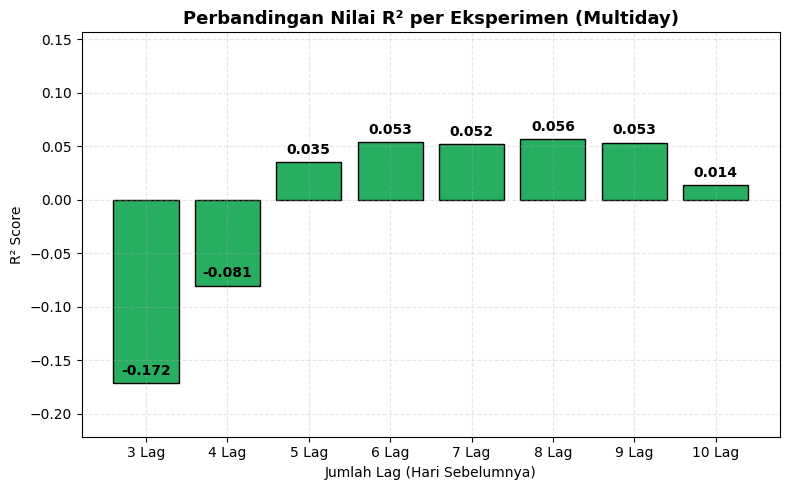

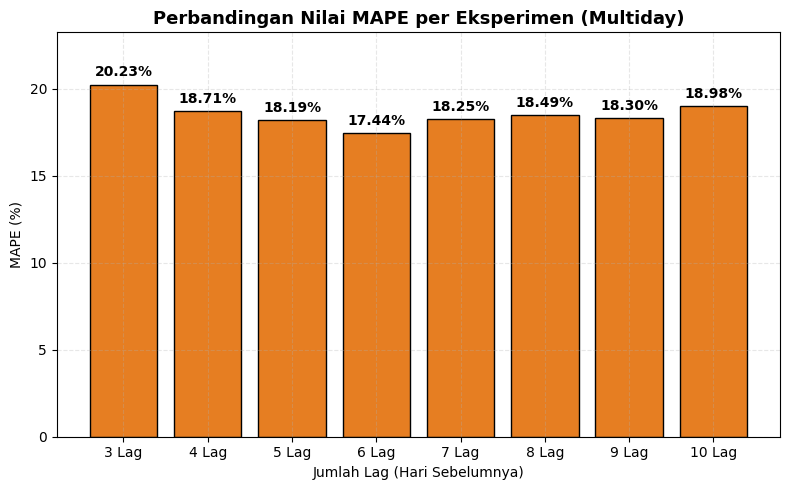

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

# === 📁 Folder input dan output ===
input_folder = "data_supervised_multiday"
output_folder = "hasil_prediksi_knn_multiday"
os.makedirs(output_folder, exist_ok=True)

# === 🗂️ Daftar file multiday ===
files = [
    ('3 Lag', f'{input_folder}/supervised_lag1_multiday.csv'),
    ('4 Lag', f'{input_folder}/supervised_lag2_multiday.csv'),
    ('5 Lag', f'{input_folder}/supervised_lag3_multiday.csv'),
    ('6 Lag', f'{input_folder}/supervised_lag4_multiday.csv'),
    ('7 Lag', f'{input_folder}/supervised_lag5_multiday.csv'),
    ('8 Lag', f'{input_folder}/supervised_lag6_multiday.csv'),
    ('9 Lag', f'{input_folder}/supervised_lag7_multiday.csv'),
    ('10 Lag', f'{input_folder}/supervised_lag8_multiday.csv'),
]

results = []

# === 🔁 Loop tiap file ===
for name, file_path in files:
    print(f"\n=== {name} ===")
    df = pd.read_csv(file_path)

    feature_cols = [col for col in df.columns if 't-' in col]  # input (lag)
    target_cols = [col for col in df.columns if 't+' in col]   # output (forecast)
    X = df[feature_cols]
    y = df[target_cols]


    # Split data (chronological, no shuffle)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Normalisasi (berdasarkan train)
    scaler = MinMaxScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)

    # Model KNN
    k = 13
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train_s, y_train)
    y_pred = knn.predict(X_test_s)

    # Evaluasi
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    r2 = r2_score(y_test, y_pred)

    print(f"RMSE : {rmse:.8f}")
    print(f"MAE  : {mae:.8f}")
    print(f"MAPE : {mape:.2f}%")
    print(f"R²   : {r2:.4f}")

    # === 💾 Simpan hasil dan scaler ke folder ===
    base_name = os.path.splitext(os.path.basename(file_path))[0]

    hasil_path = os.path.join(output_folder, f"hasil_{base_name}.csv")
    pd.DataFrame({
    'Actual': y_test.values.flatten(),
    'Predicted': y_pred.flatten()
}).to_csv(hasil_path, index=False)


    scaler_path = os.path.join(output_folder, f"scaler_{base_name}.csv")
    pd.DataFrame({'Feature': X.columns, 'Min': X.min(), 'Max': X.max()}).to_csv(scaler_path, index=False)

    print(f"✅ Hasil disimpan di: {hasil_path}")
    print(f"✅ Scaler disimpan di: {scaler_path}")

    results.append({'Eksperimen': name, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'R²': r2})

# === 📊 Ringkasan hasil ===
results_df = pd.DataFrame(results)
print("\n=== SUMMARY HASIL EKSPERIMEN ===")
print(results_df)

# Simpan summary
summary_path = os.path.join(output_folder, "summary_hasil_knn_multiday.csv")
results_df.to_csv(summary_path, index=False)
print(f"\n📁 Summary hasil disimpan di: {summary_path}")

# === 🔍 Model terbaik ===
best_idx = results_df['R²'].idxmax()
best_model = results_df.loc[best_idx]
print(f"\n🏆 Model terbaik: {best_model['Eksperimen']} → R² = {best_model['R²']:.8f}")
# === 📈 Plot perbandingan R² ===
plt.figure(figsize=(8,5))
bars_r2 = plt.bar(results_df['Eksperimen'], results_df['R²'], color='#27AE60', edgecolor='black')

# Tambahkan label nilai di atas batang
for bar in bars_r2:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2, height + 0.005,
        f'{height:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold'
    )

plt.title('Perbandingan Nilai R² per Eksperimen (Multiday)', fontsize=13, fontweight='bold')
plt.xlabel('Jumlah Lag (Hari Sebelumnya)')
plt.ylabel('R² Score')
plt.ylim(min(results_df['R²']) - 0.05, max(results_df['R²']) + 0.1)  # supaya teks tidak terpotong
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()


# === 📉 Plot perbandingan MAPE ===
plt.figure(figsize=(8,5))
bars_mape = plt.bar(results_df['Eksperimen'], results_df['MAPE'], color='#E67E22', edgecolor='black')

# Tambahkan label nilai di atas batang
for bar in bars_mape:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2, height + 0.3,
        f'{height:.2f}%', ha='center', va='bottom', fontsize=10, fontweight='bold'
    )

plt.title('Perbandingan Nilai MAPE per Eksperimen (Multiday)', fontsize=13, fontweight='bold')
plt.xlabel('Jumlah Lag (Hari Sebelumnya)')
plt.ylabel('MAPE (%)')
plt.ylim(0, max(results_df['MAPE']) + 3)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()


#### **optimasi KNN pakai GridSearchCV**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

# =====================================================
# 1️⃣ Baca data
# =====================================================
data_path = 'data_supervised_multiday/supervised_lag3_multiday.csv'
df = pd.read_csv(data_path)

target_cols = [col for col in df.columns if 't+' in col]
feature_cols = [col for col in df.columns if 't-' in col]

X = df[feature_cols]
y = df[target_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# =====================================================
# 2️⃣ Normalisasi Min-Max (hanya fit di data train)
# =====================================================
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =====================================================
# 3️⃣ Hyperparameter Tuning KNN
# =====================================================
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid = GridSearchCV(
    estimator=KNeighborsRegressor(),
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid.fit(X_train_scaled, y_train)

best_knn = grid.best_estimator_
best_params = grid.best_params_

print("\n🔍 HASIL GRID SEARCH:")
print("Best Parameters:", best_params)

# =====================================================
# 4️⃣ Evaluasi Model Terbaik
# =====================================================
y_pred = best_knn.predict(X_test_scaled)
y_pred = pd.DataFrame(y_pred, columns=target_cols, index=y_test.index)

print("\n=== HASIL EVALUASI MODEL KNN (OPTIMASI) ===")
print(f"File Data      : {data_path}")
print(f"Jumlah Data    : {len(df)} (Train: {len(X_train)}, Test: {len(X_test)})")
print(f"Best Params    : {best_params}\n")

results = []
for col in target_cols:
    rmse = np.sqrt(mean_squared_error(y_test[col], y_pred[col]))
    mae = mean_absolute_error(y_test[col], y_pred[col])
    mape = mean_absolute_percentage_error(y_test[col], y_pred[col]) * 100
    r2 = r2_score(y_test[col], y_pred[col])

    results.append([col, rmse, mae, mape, r2])
    print(f"{col}:")
    print(f"  RMSE : {rmse:.8f}")
    print(f"  MAE  : {mae:.8f}")
    print(f"  MAPE : {mape:.2f}%")
    print(f"  R²   : {r2:.4f}\n")

results_df = pd.DataFrame(results, columns=['Target', 'RMSE', 'MAE', 'MAPE', 'R²'])
results_df.loc['RATA-RATA'] = ['-', results_df['RMSE'].mean(), results_df['MAE'].mean(),
                               results_df['MAPE'].mean(), results_df['R²'].mean()]

print("=== RINGKASAN HASIL ===")
print(results_df)

output_folder = "knn_gridsearch_results"
os.makedirs(output_folder, exist_ok=True)
base_name = os.path.splitext(os.path.basename(data_path))[0]
output_name = os.path.join(output_folder, f"hasil_knn_optimasi_{base_name}.csv")

output_df = pd.concat([y_test.reset_index(drop=True), y_pred.reset_index(drop=True)], axis=1)
output_df.to_csv(output_name, index=False)
print(f"\n✅ Hasil prediksi disimpan ke folder: {output_name}")




🔍 HASIL GRID SEARCH:
Best Parameters: {'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'distance'}

=== HASIL EVALUASI MODEL KNN (OPTIMASI) ===
File Data      : data_supervised_multiday/supervised_lag3_multiday.csv
Jumlah Data    : 108 (Train: 86, Test: 22)
Best Params    : {'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'distance'}

NO2_t+1:
  RMSE : 0.00000685
  MAE  : 0.00000482
  MAPE : 17.73%
  R²   : -0.0186

NO2_t+2:
  RMSE : 0.00000679
  MAE  : 0.00000498
  MAPE : 17.99%
  R²   : -0.0264

NO2_t+3:
  RMSE : 0.00000658
  MAE  : 0.00000495
  MAPE : 18.53%
  R²   : 0.0466

=== RINGKASAN HASIL ===
            Target      RMSE       MAE       MAPE        R²
0          NO2_t+1  0.000007  0.000005  17.733439 -0.018596
1          NO2_t+2  0.000007  0.000005  17.989487 -0.026384
2          NO2_t+3  0.000007  0.000005  18.527341  0.046626
RATA-RATA        -  0.000007  0.000005  18.083423  0.000549

✅ Hasil prediksi disimpan ke folder: knn_gridsearch_results\hasil_knn_optimasi_

#### **Bagging KNN**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score


data_path = 'data_supervised_multiday/supervised_lag3_multiday.csv'  # ubah sesuai file kamu
df = pd.read_csv(data_path)

# Kolom fitur dan target
target_cols = [c for c in df.columns if 't+' in c]
feature_cols = [c for c in df.columns if 't-' in c]

X, y = df[feature_cols], df[target_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
scaler = MinMaxScaler()
X_train_s, X_test_s = scaler.fit_transform(X_train), scaler.transform(X_test)

# Simpan nilai Min-Max
min_values, max_values = scaler.data_min_, scaler.data_max_

ensemble = VotingRegressor([
    ('knn', KNeighborsRegressor(n_neighbors=8, weights='distance')),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42))
])

ensemble = MultiOutputRegressor(ensemble)
ensemble.fit(X_train_s, y_train)

y_pred = ensemble.predict(X_test_s)
y_pred = pd.DataFrame(y_pred, columns=target_cols, index=y_test.index)

print("\n=== HASIL EVALUASI MODEL ENSEMBLE (KNN + RF + XGB) ===")
print(f"File Data      : {data_path}")
print(f"Jumlah Data    : {len(df)} (Train: {len(X_train)}, Test: {len(X_test)})\n")

results = []
for col in target_cols:
    rmse = np.sqrt(mean_squared_error(y_test[col], y_pred[col]))
    mae = mean_absolute_error(y_test[col], y_pred[col])
    mape = mean_absolute_percentage_error(y_test[col], y_pred[col]) * 100
    r2 = r2_score(y_test[col], y_pred[col])
    results.append([col, rmse, mae, mape, r2])

# Ringkasan
results_df = pd.DataFrame(results, columns=['Target', 'RMSE', 'MAE', 'MAPE', 'R²'])
results_df.loc['RATA-RATA'] = ['-', results_df['RMSE'].mean(), results_df['MAE'].mean(),
                               results_df['MAPE'].mean(), results_df['R²'].mean()]

print("=== RINGKASAN HASIL ===")
print(results_df)

output_folder = "bagging_knn"
os.makedirs(output_folder, exist_ok=True)
base_name = os.path.splitext(os.path.basename(data_path))[0]
output_df = pd.concat([y_test.reset_index(drop=True), y_pred.reset_index(drop=True)], axis=1)
output_name = os.path.join(output_folder, f"hasil_ensemble_{base_name}.csv")
output_df.to_csv(output_name, index=False)
print(f"\n✅ Hasil prediksi disimpan ke: {output_name}")

scaler_df = pd.DataFrame({'Feature': X.columns, 'Min': min_values, 'Max': max_values})
scaler_file = os.path.join(output_folder, f"scaler_min-max_{base_name}.csv")
scaler_df.to_csv(scaler_file, index=False)
print(f"✅ Parameter Min-Max disimpan ke: {scaler_file}")


=== HASIL EVALUASI MODEL ENSEMBLE (KNN + RF + XGB) ===
File Data      : data_supervised_multiday/supervised_lag3_multiday.csv
Jumlah Data    : 108 (Train: 86, Test: 22)

=== RINGKASAN HASIL ===
            Target      RMSE       MAE       MAPE        R²
0          NO2_t+1  0.000007  0.000005  18.275573 -0.124637
1          NO2_t+2  0.000007  0.000005  17.239180 -0.007861
2          NO2_t+3  0.000007  0.000005  18.503201 -0.035667
RATA-RATA        -  0.000007  0.000005  18.005984 -0.056055

✅ Hasil prediksi disimpan ke: bagging_knn\hasil_ensemble_supervised_lag3_multiday.csv
✅ Parameter Min-Max disimpan ke: bagging_knn\scaler_min-max_supervised_lag3_multiday.csv


### **Stacking Ensemble (gabung KNN + RF + XGBoost)**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("data_supervised_multiday/supervised_lag3_multiday.csv")

# asumsi: kolom target ada 3 (multi-day)
targets = ["NO2_t+1", "NO2_t+2", "NO2_t+3"]
features = [c for c in df.columns if c not in targets]

print(df.head(3))
print(f"\n{len(df)} rows × {len(df.columns)} columns\n")

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df[features])
X_scaled = pd.DataFrame(X_scaled, columns=features)

print("📊 Nilai Min-Max fitur:")
for col in features[-3:]:
    print(f"{col:<10} → Min: {df[col].min():.8f} | Max: {df[col].max():.8f}")

param_grid = {
    "n_neighbors": range(3, 16),
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"]
}

X = X_scaled
results = []

print("\n🔍 Grid Search dimulai...")
for target in targets:
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    grid = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring="neg_mean_absolute_percentage_error")
    grid.fit(X_train, y_train)

    best_knn = grid.best_estimator_
    y_pred = best_knn.predict(X_test)

    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    r2 = r2_score(y_test, y_pred)

    print(f"\n{target}:")
    print(f"  RMSE : {rmse:.8f}")
    print(f"  MAE  : {mae:.8f}")
    print(f"  MAPE : {mape:.2f}%")
    print(f"  R²   : {r2:.4f}")

    results.append([target, rmse, mae, mape, r2])

res_df = pd.DataFrame(results, columns=["Target", "RMSE", "MAE", "MAPE", "R²"])
res_df.loc["RATA-RATA"] = [
    "-",
    res_df["RMSE"].mean(),
    res_df["MAE"].mean(),
    res_df["MAPE"].mean(),
    res_df["R²"].mean(),
]

print("\n=== RINGKASAN HASIL ===")
print(res_df)

import os

# === Buat folder penyimpanan jika belum ada ===
output_dir = "hasil_model_ensemble_knn_multiday"
os.makedirs(output_dir, exist_ok=True)

# === Simpan hasil prediksi dan parameter Min-Max ke folder itu ===
res_df.to_csv(f"{output_dir}/hasil_knn_optimasi_supervised_lag3_multiday.csv", index=False)
pd.DataFrame({
    "Fitur": features,
    "Min": [df[c].min() for c in features],
    "Max": [df[c].max() for c in features]
}).to_csv(f"{output_dir}/scaler_min-max_supervised_lag3_multiday.csv", index=False)

print("\n✅ Hasil prediksi disimpan ke folder:", output_dir)
print("   ├── hasil_knn_optimasi_supervised_lag3_multiday.csv")
print("   └── scaler_min-max_supervised_lag3_multiday.csv")

print(f"\n🔍 HASIL GRID SEARCH (terakhir): {grid.best_params_}")


    NO2_t-5   NO2_t-4   NO2_t-3   NO2_t-2   NO2_t-1   NO2_t+1   NO2_t+2  \
0  0.000030  0.000030  0.000027  0.000033  0.000040  0.000020  0.000022   
1  0.000030  0.000027  0.000033  0.000040  0.000036  0.000022  0.000023   
2  0.000027  0.000033  0.000040  0.000036  0.000020  0.000023  0.000025   

    NO2_t+3  
0  0.000023  
1  0.000025  
2  0.000027  

108 rows × 8 columns

📊 Nilai Min-Max fitur:
NO2_t-3    → Min: 0.00001091 | Max: 0.00005871
NO2_t-2    → Min: 0.00001091 | Max: 0.00005871
NO2_t-1    → Min: 0.00001091 | Max: 0.00005871

🔍 Grid Search dimulai...

NO2_t+1:
  RMSE : 0.00000734
  MAE  : 0.00000527
  MAPE : 29.15%
  R²   : -0.2053

NO2_t+2:
  RMSE : 0.00000775
  MAE  : 0.00000545
  MAPE : 25.63%
  R²   : 0.0055

NO2_t+3:
  RMSE : 0.00000721
  MAE  : 0.00000542
  MAPE : 28.71%
  R²   : 0.3120

=== RINGKASAN HASIL ===
            Target      RMSE       MAE       MAPE        R²
0          NO2_t+1  0.000007  0.000005  29.153032 -0.205335
1          NO2_t+2  0.000008  0.000005